In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
import torch
import torch.nn.functional as F
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device, torch.zeros(1).cuda(), torch.cuda.empty_cache()
# device
# torch.cuda.is_available()

('cuda:0', tensor([0.], device='cuda:0'), None)

In [4]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

E:\python\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
E:\python\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
E:\python\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
from tokenizers.tools import EncodingVisualizer
from tokenizers.pre_tokenizers import Digits
from transformers import XLMTokenizer, AutoModel, AutoTokenizer, PreTrainedTokenizerFast

In [6]:
s = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ';', '=', '$', ',']
print(''.join(s), file=open('dummy.txt', 'w'), end='')

In [7]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Digits(individual_digits=True)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
trainer = trainers.BpeTrainer(vocab_size=len(s)+1, special_tokens=["<|endoftext|>"])
tokenizer.train(["dummy.txt"], trainer=trainer)
tokenizer.decoder = decoders.ByteLevel()
# sentence = "278524+748867="
# encoding = tokenizer.encode(sentence)
# encoding.word_ids

In [8]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<|endoftext|>",
    eos_token="<|endoftext|>",
)

In [9]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

E:\python\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
tokenizer.get_vocab()

{'4': 8,
 '2': 6,
 '$': 1,
 '<|endoftext|>': 0,
 '3': 7,
 '7': 11,
 '9': 13,
 '+': 2,
 '5': 9,
 '1': 5,
 '=': 15,
 ';': 14,
 '6': 10,
 '0': 4,
 ',': 3,
 '8': 12}

In [11]:
def generate_addition(a, b):
    text = "%d+%d;" % (a, b)
    carry = 0
    s = a+b
    while True:
        text += "%d%d%d" % (a % 10, b % 10, carry)
        if a == 0 and b == 0 and carry == 0:
            break
        text += "%d" % ((a+b+carry)%10)
        carry = (a%10+b%10+carry)//10
        a = a//10
        b = b//10
        text += ','
    text += "=%d" % s
    return text + '$<|endoftext|>'

generate_addition(199456, 654321)

'199456+654321;6107,5207,4307,9403,9515,1618,000=853777$<|endoftext|>'

In [12]:
import numpy as np

import sys
np.set_printoptions(suppress=True, threshold=sys.maxsize)

import pandas as pd
n_digits = 5

a = np.empty((2, 0))
for i in range(n_digits):
    for j in range(n_digits):
        # b = np.random.randint(10**(i), 10**(i+1), (1, int(10**(i+j+1))))
        # c = np.random.randint(10**(j), 10**(j+1), (1, int(10**(i+j+1))))
        # b = np.random.randint(10**(i), 10**(i+1), (1, int(10**(4 if i < 4 or j < 4 else 5))))
        # c = np.random.randint(10**(j), 10**(j+1), (1, int(10**(4 if i < 4 or j < 4 else 5))))
        b = np.random.randint(10**(i), 10**(i+1), (1, int(10**(4))))
        c = np.random.randint(10**(j), 10**(j+1), (1, int(10**(4))))
        a = np.append(a, np.append(b, c, axis=0), axis=1)

for i in range(n_digits):
    b = np.random.randint(10**(n_digits), 10**(n_digits) + 10**(i), (1, int(10**(4))))
    c = np.random.randint(10**(i), 10**(i+1), (1, int(10**(4))))
    a = np.append(a, np.append(b-c, c, axis=0), axis=1)
    
    
# a = np.random.randint(10**(n_digits-1), 10**n_digits, (2, 100000))
# a = np.random.randint(0, 10**n_digits, (2, 200000))

df = pd.DataFrame(a.T)
# df['expr'] = df[0]+'+'+df[1]+';='+df[2]+'$'
df['expr'] = df.apply(lambda row: generate_addition(row[0], row[1]), axis=1)

df.head(), a.shape
# a

(     0    1                                expr
 0  7.0  6.0  7+6;7603,0011,000=13$<|endoftext|>
 1  4.0  1.0        4+1;4105,000=5$<|endoftext|>
 2  2.0  3.0        2+3;2305,000=5$<|endoftext|>
 3  6.0  6.0  6+6;6602,0011,000=12$<|endoftext|>
 4  1.0  6.0        1+6;1607,000=7$<|endoftext|>,
 (2, 300000))

In [13]:
df.tail()

,0,1,expr
299995,82515.0,20581.0,"82515+20581;5106,1809,5500,2013,8200,0011,000=..."
299996,72116.0,37154.0,"72116+37154;6400,1517,1102,2709,7300,0011,000=..."
299997,34028.0,71812.0,"34028+71812;8200,2114,0808,4105,3700,0011,000=..."
299998,36914.0,64408.0,"36914+64408;4802,1012,9403,6411,3610,0011,000=..."
299999,90761.0,16862.0,"90761+16862;1203,6602,7816,0617,9100,0011,000=..."


In [14]:
context_length = len(generate_addition(10**n_digits-1, 10**n_digits-1))+1
context_length

67

In [15]:
from transformers import GPT2LMHeadModel, AutoConfig

# config = AutoConfig.from_pretrained(
#     "gpt2",
#     vocab_size=len(tokenizer),
#     bos_token_id=tokenizer.bos_token_id,
#     eos_token_id=tokenizer.eos_token_id, 
#     max_new_tokens=context_length,
#     n_layer=3,
#     n_head=3,
# )

# model = GPT2LMHeadModel(config)
# model = model.to(device)

model = GPT2LMHeadModel.from_pretrained('calc-gpt-2', local_files_only=True)

model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 22.1M parameters


In [16]:
from sklearn.model_selection import train_test_split
train, eval = train_test_split(df['expr'])

In [17]:
train_dataset = torch.Tensor(tokenizer(
    # list(df['expr'].values[:90000]),
    list(train),
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True, padding=True
)['input_ids']).to(torch.int64)

eval_dataset = torch.Tensor(tokenizer(
    # list(df['expr'].values[90000:]),
    list(eval),
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True, padding=True
)['input_ids']).to(torch.int64)

In [18]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak. 
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids

In [19]:
tokenizer.encode('=')[0], tokenizer.encode('$')[0]

(15, 1)

In [20]:
from huggingface_hub.utils import insecure_hashlib

In [21]:
import datasets
from sklearn.metrics import hamming_loss

eq_id = tokenizer.encode('=')[0]
dollar_sign_id = tokenizer.encode('$')[0]

def compute_metrics(eval_preds):
    total_loss = 0
    len_mismatch = 0
    bad_format = 0
    good_format = 0
    for pred, label in zip(*eval_preds):
        from_p = np.argwhere(pred == eq_id).reshape(-1)
        from_l = np.argwhere(label == eq_id).reshape(-1)
        to_p = np.argwhere(pred == dollar_sign_id).reshape(-1)
        to_l = np.argwhere(label == dollar_sign_id).reshape(-1)
#         print(type(from_p), type(from_l))
#         print(from_p.shape, from_l.shape)
#         print(from_p, from_l)
        if len(from_p) == 0 or len(from_l) == 0 or len(to_p) == 0 or len(to_l) == 0:
            bad_format += 1
            # print(pred, label)
            continue
#         pred = pred[from_p[-1]+1:to_p[0]]
#         label = label[from_l[-1]+1:to_l[0]]
        pred = pred[from_p[0]+1:to_p[0]]
        label = label[from_l[0]+1:to_l[0]]
        if len(pred) != len(label):
            len_mismatch += 1
            # print(pred, label)
            continue
        else:
            good_format += 1
            total_loss += hamming_loss(pred, label)
            # if hamming_loss(pred, label) != 0:
            #     print(pred, label)
#     print(tokenizer.decode(eval_preds[0][-1]), tokenizer.decode(eval_preds[1][-1][:-1]))
#     print(eval_preds[0][-1], eval_preds[1][-1][:-1])
#     print(tokenizer.decode(pred), tokenizer.decode(label))
#     print(pred, label)
    return {
        "calc_loss": 1.0*total_loss/good_format if good_format != 0 else 1,
        "len_mismatch": len_mismatch,
        "bad_format": bad_format,
        "good_format": good_format
    }
eq_id

15

In [22]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

print_gpu_utilization()

GPU memory occupied: 1555 MB.


In [23]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="calc-gpt-2",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=500,
    gradient_accumulation_steps=8,
    num_train_epochs=10,
    weight_decay=0.1,
    warmup_steps=10,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=300,
    fp16=True,
    push_to_hub=True,
)


trainer = Trainer(
    model=model.to(device),
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
#     compute_metrics=compute_metrics_acc(tokenizer)
    compute_metrics=compute_metrics,
)

In [145]:
trainer.train()

Step,Training Loss,Validation Loss,Calc Loss,Len Mismatch,Bad Format,Good Format,Runtime,Samples Per Second,Steps Per Second
500,0.389200,0.383361,0.000000,0,0,75000,42.289100,1773.505000,55.428000
1000,0.388300,0.383074,0.000000,0,0,75000,42.638100,1758.989000,54.974000
1500,0.387200,0.383014,0.000000,3,0,74997,43.129500,1738.948000,54.348000
2000,0.386700,0.383058,0.000000,1,0,74999,42.567600,1761.905000,55.065000
2500,0.386000,0.382617,0.000000,0,0,75000,46.690100,1606.336000,50.203000
3000,0.384900,0.382340,0.000000,0,0,75000,48.526700,1545.541000,48.303000
3500,0.384700,0.382312,0.000000,1,0,74999,46.249100,1621.653000,50.682000
4000,0.384200,0.382129,0.000000,0,0,75000,47.036900,1594.492000,49.833000
4500,0.383600,0.382117,0.000000,0,0,75000,46.725600,1605.114000,50.165000
5000,0.383600,0.381881,0.000000,0,0,75000,51.199300,1464.863000,45.782000


TrainOutput(global_step=8790, training_loss=0.3841435307664405, metrics={'train_runtime': 3296.015, 'train_samples_per_second': 682.643, 'train_steps_per_second': 2.667, 'total_flos': 1.5502295808e+16, 'train_loss': 0.3841435307664405, 'epoch': 10.0})

_________________________________________________________

In [416]:
trainer.evaluate(eval_dataset)

{'eval_loss': 0.3815824091434479,
 'eval_calc_loss': 0.0,
 'eval_len_mismatch': 0,
 'eval_bad_format': 0,
 'eval_good_format': 75000,
 'eval_runtime': 46.7215,
 'eval_samples_per_second': 1605.258,
 'eval_steps_per_second': 50.17}

_________________________________________________________

In [123]:
torch.cuda.empty_cache()
model = GPT2LMHeadModel.from_pretrained('calc-gpt-2', local_files_only=True)

In [124]:
# def custom_stopping_criteria(input_ids: torch.LongTensor, score: torch.FloatTensor, **kwargs) -> bool:
#     return your_condition

# stopping_criteria = StoppingCriteriaList([custom_stopping_criteria])

from transformers import StoppingCriteriaList, StoppingCriteria

dollar_sign_id = tokenizer.encode('$')[0]

class EosListStoppingCriteria(StoppingCriteria):
    def __init__(self, eos_sequence = [dollar_sign_id]):
        self.eos_sequence = eos_sequence

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_ids = input_ids[:,-len(self.eos_sequence):].tolist()
        return self.eos_sequence in last_ids

In [125]:
a = 86430
b = 21568

inputs = tokenizer.encode(f"{a}+{b};", return_tensors="pt").to(device)
# inputs = tokenizer.encode(f"010+050;", return_tensors="pt").to(device)
# inputs = tokenizer.encode("107+507;7704,0011,150", return_tensors="pt").to(device)
outputs = model.to(device).generate(
    inputs, 
    stopping_criteria=[EosListStoppingCriteria()],
    max_new_tokens = context_length,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(outputs[0]), a+b)
# print(tokenizer.decode(outputs[0]))
res = tokenizer.decode(outputs[0])
out = model(inputs, output_attentions=True)
inputs = tokenizer.encode(res, return_tensors="pt").to(device)

86430+21568;0808,3609,4509,6107,8200,0011,000=107998$ 107998


_________________________________________________________

In [126]:
from bertviz import model_view, head_view, neuron_view, transformers_neuron_view
from js2py import require

In [127]:
inputs = tokenizer.encode(res, return_tensors="pt").to(device)
out = model(inputs, output_attentions=True)

In [128]:
model_view(out.attentions, res, cross_attention=out.cross_attentions)

<IPython.core.display.Javascript object>

In [129]:
head_view(out.attentions, res)

<IPython.core.display.Javascript object>

_________________________________________________________

In [ ]:
model.forward(inputs)

In [ ]:
inputs = tokenizer.encode("0123456789+;=,$", return_tensors="pt").to(device)
embs = model.transformer.wte.forward(inputs)[0]

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

dim_redused = TSNE(init='pca').fit_transform(embs.cpu().detach().numpy())

plt.scatter(dim_redused[:, 0], dim_redused[:, 1], c=[i for i in range(15)], label=[i for i in "0123456789+;=,$"])
plt.legend()

In [ ]:
model._modules

In [ ]:
model.__dict__

In [157]:
model.save_pretrained('.')

_________________________________________________________

In [429]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure(figsize=(40, 40))
    for j, atts in enumerate(attentions):
        for i, att in enumerate(atts[0]):
            # ax = fig.add_subplot(int(f'{(len(atts[0])+1)*len(attentions)}{j+1}{i+1}'))
            ax = plt.subplot2grid((len(atts[0])+1, len(attentions)), (i, j))
            cax = ax.matshow(att.detach().cpu().numpy(), cmap='plasma')
            fig.colorbar(cax)
            ax.set_title(['0 head', '1 head', '2 head', ][i] + f' layer {j}')
        
            # Set up axes
            ax.set_xticklabels([' '] + input_sentence +
                               ['<EOS>'])
            ax.set_yticklabels([''] + output_words)
            
            # Show label at every tick
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
        # ax = fig.add_subplot(int(f'{(len(atts[0])+1)*len(attentions)}{j+1}{len(atts[0])+1}'))
        ax = plt.subplot2grid((4, 3), (i+1, j))
        
        # print()
        cax = ax.matshow(atts[0].sum(axis=0).detach().cpu().numpy(), cmap='plasma')
        fig.colorbar(cax)
        ax.set_title('sum of heads')
    
        # Set up axes
        ax.set_xticklabels([' '] + input_sentence +
                           ['<EOS>'])
        ax.set_yticklabels([''] + output_words)
    
        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

C:\Users\Tim\AppData\Local\Temp\ipykernel_28456\3580813082.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([' '] + input_sentence +
C:\Users\Tim\AppData\Local\Temp\ipykernel_28456\3580813082.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
C:\Users\Tim\AppData\Local\Temp\ipykernel_28456\3580813082.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([' '] + input_sentence +
C:\Users\Tim\AppData\Local\Temp\ipykernel_28456\3580813082.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
C:\Users\Tim\AppData\Local\Temp\ipykernel_28456\

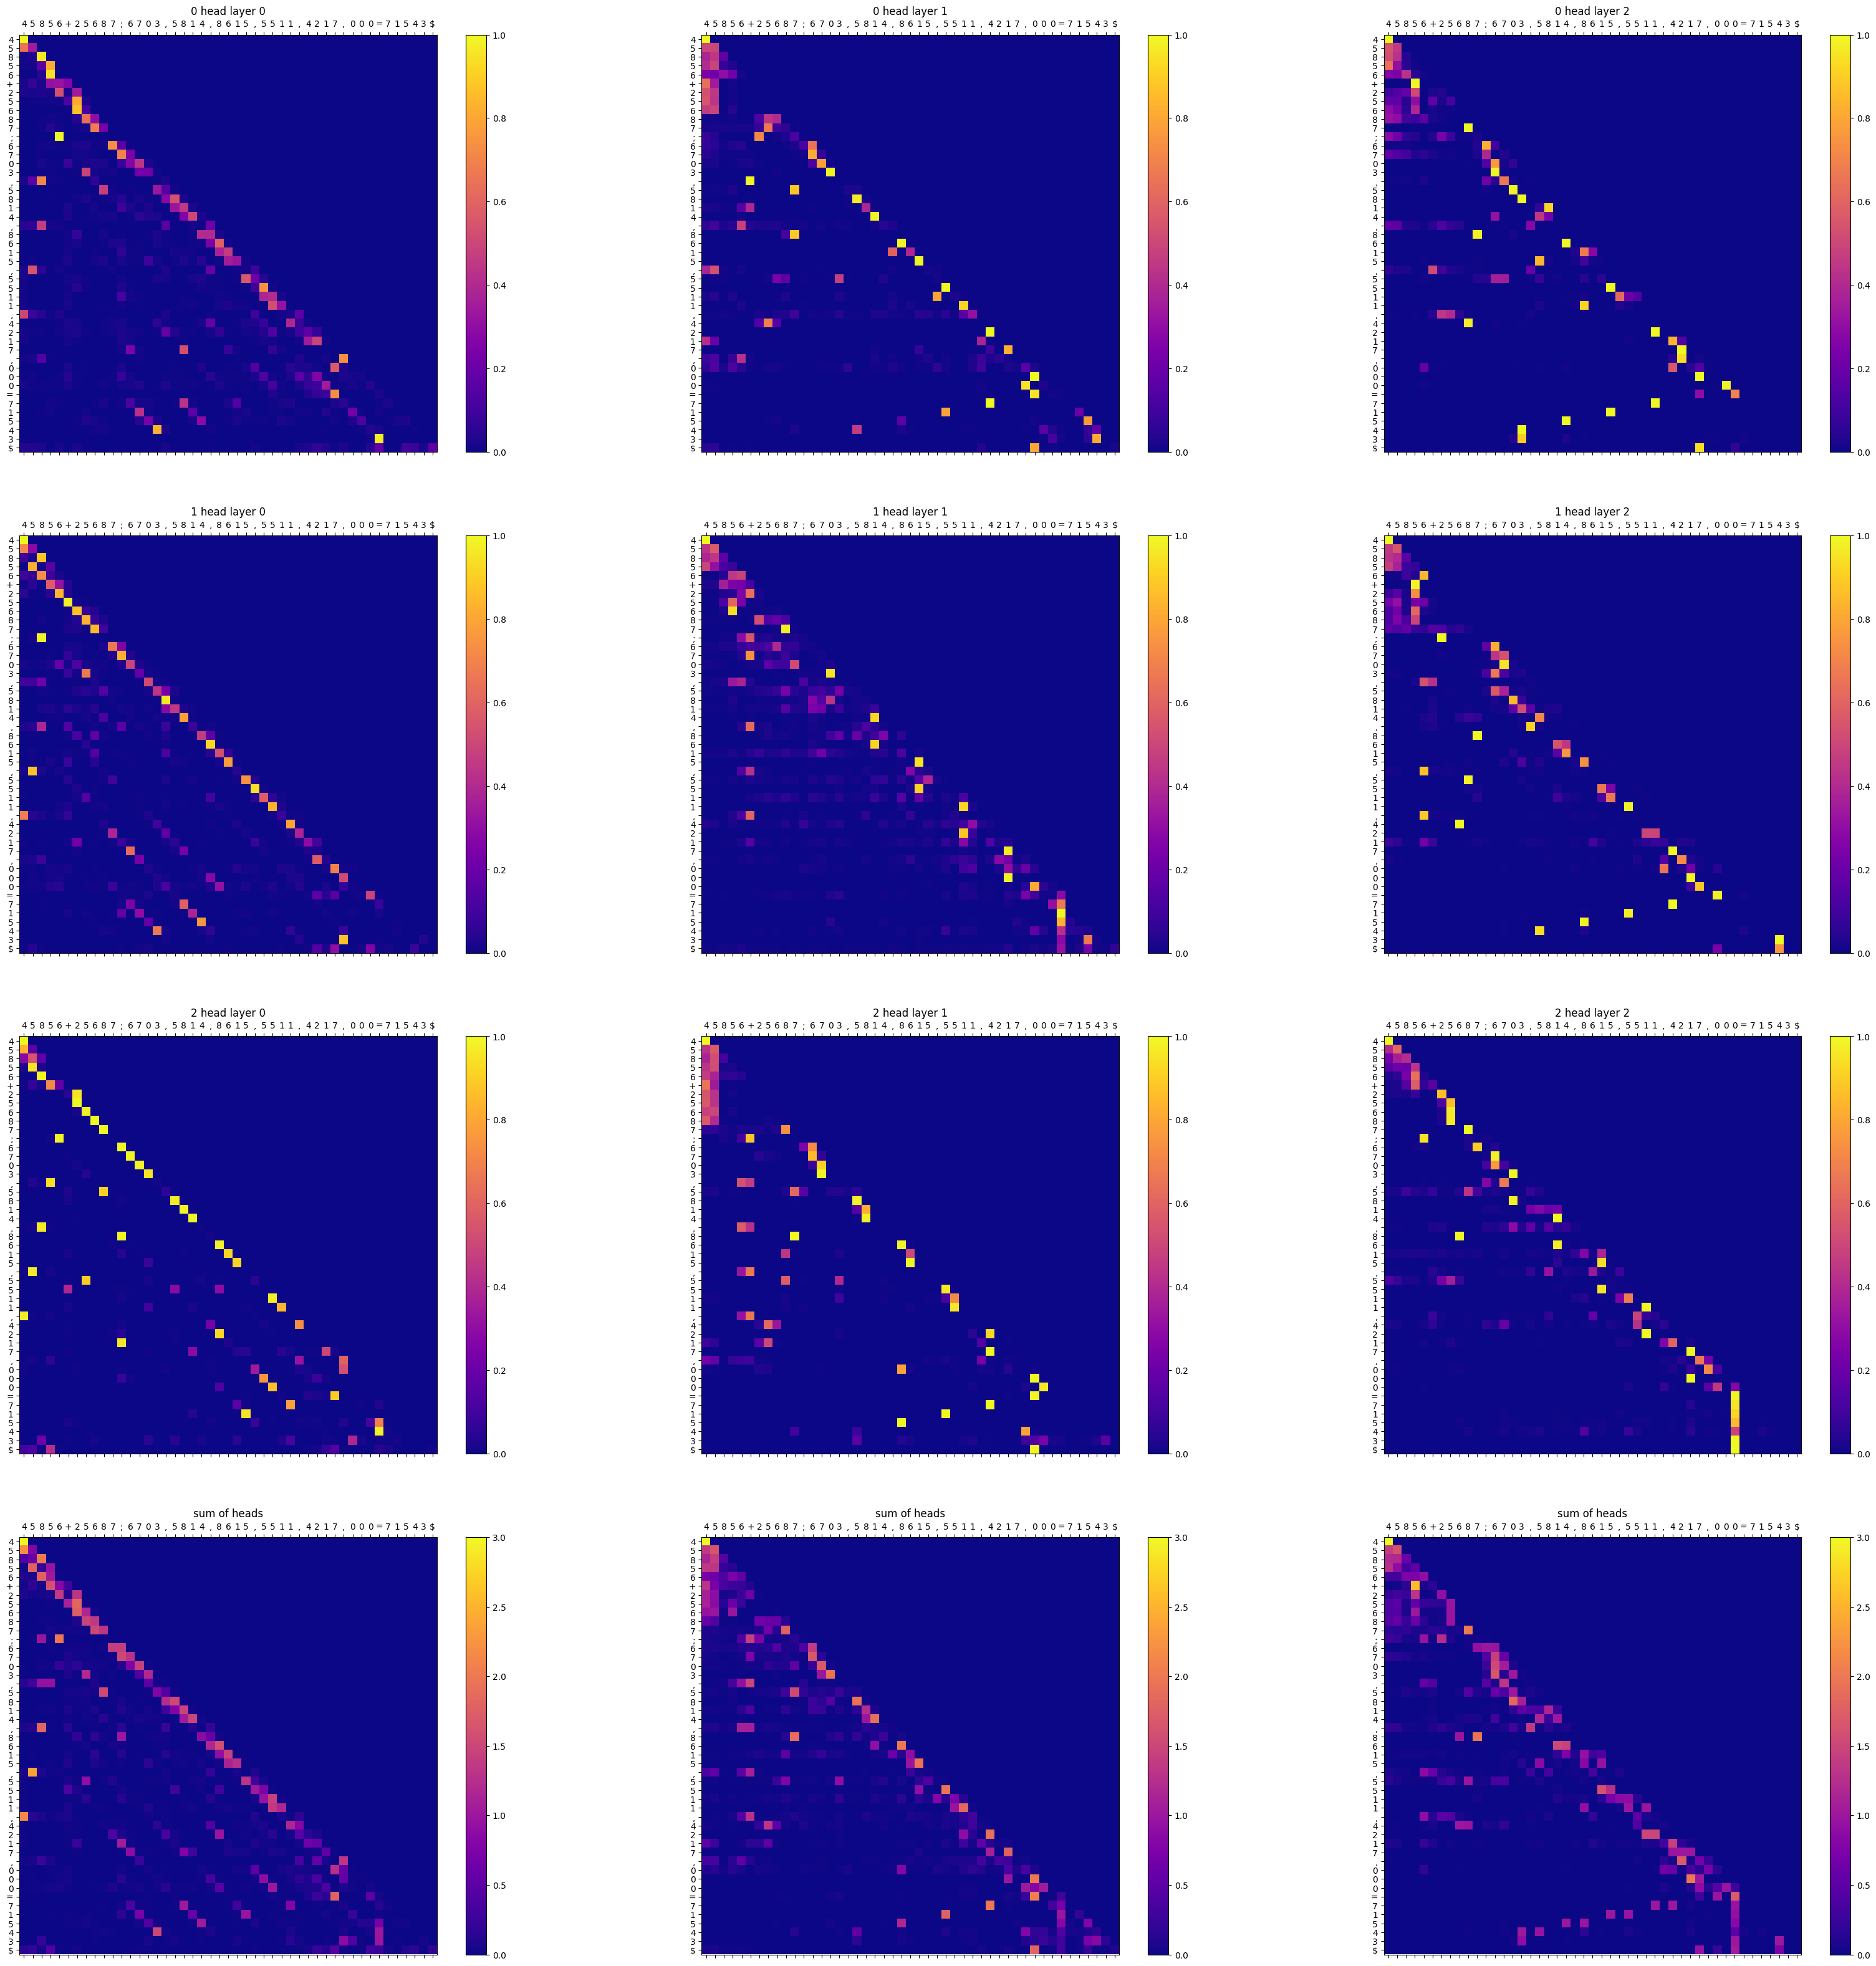

In [430]:
l = [i for i in res]
showAttention(l, l, out.attentions)

_________________________________________________________

In [58]:
import wandb
wandb.init(mode='disabled')

In [ ]:

semicolon_id = tokenizer.encode(';')[0]
comma_id = tokenizer.encode(',')[0]

In [101]:
for layer in [0, 1, 2]:
    for heads in [
        [0], [1], [2], 
        [0, 1], [1, 2], [0, 2], 
    ]:
        model = GPT2LMHeadModel.from_pretrained('calc-gpt-2', local_files_only=True)
        model.prune_heads({
            layer: heads,
        })

        def compute_metrics(eval_preds):
            file = open(f'log_{layer}_{heads}.txt', 'a')
            # file = open(f'log_.txt', 'a')
            # total_loss = 0
            # len_mismatch = 0
            # bad_format = 0
            # good_format = 0
            service_token_acc = 0
            first_digit_retrieval_acc = 0
            second_digit_retrieval_acc = 0
            carry_digit_acc = 0
            addition_digits_acc = 0
            final_answer_acc = 0
            for pred, label in zip(*eval_preds):
                service_tokens_mask = np.where((label == comma_id) + (label == eq_id) + (label == dollar_sign_id)) # служебные токены
                first_digit_retrieval_mask = (np.where((label == comma_id) + (label == semicolon_id)) + np.array(1))[0] # первое число
                second_digit_retrieval_mask = (np.where((label == comma_id) + (label == semicolon_id)) + np.array(2))[0] # второе число
                carry_digit_mask = (np.where((label == comma_id) + (label == semicolon_id)) + np.array(3))[0] # carry digits
                addition_digits_mask = (np.where((label == comma_id)) + np.array(-1))[0] # результат сложения поразрядно
                final_answer_mask = np.arange((np.where((label == eq_id)) + np.array(1))[0], np.where((label == dollar_sign_id))[0]) # итоговый результат
                # print(service_tokens_mask, first_digit_retrieval_mask, second_digit_retrieval_mask, carry_digit_mask, addition_digits_mask)
                service_token_acc += np.sum(
                    pred[service_tokens_mask[0]-1] == label[service_tokens_mask])/len(service_tokens_mask[0])
                first_digit_retrieval_acc += np.sum(
                    pred[first_digit_retrieval_mask-1] == label[first_digit_retrieval_mask])/len(first_digit_retrieval_mask)
                second_digit_retrieval_acc += np.sum(
                    pred[second_digit_retrieval_mask-1] == label[second_digit_retrieval_mask])/len(second_digit_retrieval_mask)
                carry_digit_acc += np.sum(
                    pred[carry_digit_mask-1] == label[carry_digit_mask])/len(carry_digit_mask)
                addition_digits_acc += np.sum(
                    pred[addition_digits_mask-1] == label[addition_digits_mask])/len(addition_digits_mask)
                final_answer_acc += np.sum(
                    pred[final_answer_mask-1] == label[final_answer_mask])/len(final_answer_mask)
                
                # print(f'b/f:_{tokenizer.decode(pred[np.where(pred >= 0)])}\ncor:{tokenizer.decode(label[np.where(label >= 0)])}', file=file)
                # print(service_token_acc, first_digit_retrieval_acc, second_digit_retrieval_acc, carry_digit_acc, addition_digits_acc, final_answer_acc, file=file)
                # break
                # from_p = np.argwhere(pred == eq_id).reshape(-1)
                # from_l = np.argwhere(label == eq_id).reshape(-1)
                # to_p = np.argwhere(pred == dollar_sign_id).reshape(-1)
                # to_l = np.argwhere(label == dollar_sign_id).reshape(-1)
                # if len(from_p) == 0 or len(from_l) == 0 or len(to_p) == 0 or len(to_l) == 0:
                #     bad_format += 1
                #     print(f'b/f:_{tokenizer.decode(pred[np.where(pred >= 0)])}\ncor:{tokenizer.decode(label[np.where(label >= 0)])}', file=file)
                #     continue
                # pred_ans = pred[from_p[0]+1:to_p[0]]
                # label_ans = label[from_l[0]+1:to_l[0]]
                # if len(pred_ans) != len(label_ans):
                #     len_mismatch += 1
                #     print(f'b/l:_{tokenizer.decode(pred[np.where(pred >= 0)])}\ncor:{tokenizer.decode(label[np.where(label >= 0)])}', file=file)
                #     continue
                # else:
                #     good_format += 1
                #     total_loss += hamming_loss(pred_ans, label_ans)
                #     if hamming_loss(pred_ans, label_ans) != 0:
                #         print(f'w/a:_{tokenizer.decode(pred[np.where(pred >= 0)])}\ncor:{tokenizer.decode(label[np.where(label >= 0)])}', file=file)
            print(
                service_token_acc, first_digit_retrieval_acc, 
                second_digit_retrieval_acc, carry_digit_acc, 
                addition_digits_acc, final_answer_acc, file=file)
                
            return {
                # "calc_loss": 1.0*total_loss/good_format if good_format != 0 else 1,
                # "len_mismatch": len_mismatch,
                # "bad_format": bad_format,
                # "good_format": good_format,
                "service_token_acc": service_token_acc/len(eval_preds[0]) * 100,
                "first_digit_retrieval_acc": first_digit_retrieval_acc/len(eval_preds[0]) * 100,
                "second_digit_retrieval_acc": second_digit_retrieval_acc/len(eval_preds[0]) * 100,
                "carry_digit_acc": carry_digit_acc/len(eval_preds[0]) * 100,
                "addition_digits_acc": addition_digits_acc/len(eval_preds[0]) * 100,
                "final_answer_acc": final_answer_acc/len(eval_preds[0]) * 100
            }
        
        trainer = Trainer(
            model=model.to(device),
            tokenizer=tokenizer,
            args=args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        #     compute_metrics=compute_metrics_acc(tokenizer)
            compute_metrics=compute_metrics,
        )
        print(trainer.evaluate(eval_dataset))

C:\Users\Tim\AppData\Local\Temp\ipykernel_30804\2406367808.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_answer_mask = np.arange((np.where((label == eq_id)) + np.array(1))[0], np.where((label == dollar_sign_id))[0]) # итоговый результат


{'eval_loss': 0.38469576835632324, 'eval_service_token_acc': 99.95542063492088, 'eval_first_digit_retrieval_acc': 99.99892063492062, 'eval_second_digit_retrieval_acc': 99.9115619047623, 'eval_carry_digit_acc': 99.90536507936534, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 99.44811111111206, 'eval_runtime': 42.0035, 'eval_samples_per_second': 1785.565, 'eval_steps_per_second': 55.805}


{'eval_loss': 0.3826732039451599, 'eval_service_token_acc': 99.94269841269873, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 99.9987619047619, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 99.99746666666668, 'eval_final_answer_acc': 99.92448888888937, 'eval_runtime': 41.597, 'eval_samples_per_second': 1803.013, 'eval_steps_per_second': 56.35}


{'eval_loss': 0.38194790482521057, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 99.9984, 'eval_carry_digit_acc': 99.99828571428571, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 46.854, 'eval_samples_per_second': 1600.717, 'eval_steps_per_second': 50.028}


{'eval_loss': 1.3774462938308716, 'eval_service_token_acc': 63.48389365077865, 'eval_first_digit_retrieval_acc': 82.10478095237839, 'eval_second_digit_retrieval_acc': 75.25080000000425, 'eval_carry_digit_acc': 78.86603174603405, 'eval_addition_digits_acc': 43.70893333333539, 'eval_final_answer_acc': 45.40426666665518, 'eval_runtime': 45.234, 'eval_samples_per_second': 1658.045, 'eval_steps_per_second': 51.819}


{'eval_loss': 0.5987482070922852, 'eval_service_token_acc': 97.79239523810251, 'eval_first_digit_retrieval_acc': 90.05969523812541, 'eval_second_digit_retrieval_acc': 85.50255238095677, 'eval_carry_digit_acc': 96.61593333334389, 'eval_addition_digits_acc': 98.83000000000473, 'eval_final_answer_acc': 92.18242222223493, 'eval_runtime': 41.511, 'eval_samples_per_second': 1806.75, 'eval_steps_per_second': 56.467}


{'eval_loss': 0.7534730434417725, 'eval_service_token_acc': 90.75510793652643, 'eval_first_digit_retrieval_acc': 85.08991111112387, 'eval_second_digit_retrieval_acc': 79.03411746032971, 'eval_carry_digit_acc': 96.58793968254685, 'eval_addition_digits_acc': 77.48466666667086, 'eval_final_answer_acc': 89.84991111111877, 'eval_runtime': 42.3149, 'eval_samples_per_second': 1772.423, 'eval_steps_per_second': 55.394}


{'eval_loss': 0.38194945454597473, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 49.0347, 'eval_samples_per_second': 1529.53, 'eval_steps_per_second': 47.803}


{'eval_loss': 0.3820250928401947, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 99.99804444444446, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 43.511, 'eval_samples_per_second': 1723.701, 'eval_steps_per_second': 53.871}


{'eval_loss': 0.38195523619651794, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 40.791, 'eval_samples_per_second': 1838.641, 'eval_steps_per_second': 57.464}


{'eval_loss': 0.38251420855522156, 'eval_service_token_acc': 99.99961904761905, 'eval_first_digit_retrieval_acc': 99.9997777777778, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.514, 'eval_samples_per_second': 1806.619, 'eval_steps_per_second': 56.463}


{'eval_loss': 0.3827035427093506, 'eval_service_token_acc': 99.98453333333346, 'eval_first_digit_retrieval_acc': 99.9782825396826, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 39.9206, 'eval_samples_per_second': 1878.731, 'eval_steps_per_second': 58.717}


{'eval_loss': 0.3887840807437897, 'eval_service_token_acc': 99.99961904761905, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 99.9997777777778, 'eval_carry_digit_acc': 99.9928888888889, 'eval_addition_digits_acc': 99.98726666666674, 'eval_final_answer_acc': 100.0, 'eval_runtime': 39.1564, 'eval_samples_per_second': 1915.395, 'eval_steps_per_second': 59.862}


{'eval_loss': 0.3818717300891876, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.284, 'eval_samples_per_second': 1816.684, 'eval_steps_per_second': 56.777}


{'eval_loss': 0.38198956847190857, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.598, 'eval_samples_per_second': 1802.971, 'eval_steps_per_second': 56.349}


{'eval_loss': 0.382182240486145, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.006, 'eval_samples_per_second': 1829.001, 'eval_steps_per_second': 57.162}


{'eval_loss': 0.38221630454063416, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 42.2539, 'eval_samples_per_second': 1774.985, 'eval_steps_per_second': 55.474}


{'eval_loss': 0.38262900710105896, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 42.6445, 'eval_samples_per_second': 1758.727, 'eval_steps_per_second': 54.966}


{'eval_loss': 0.3822505474090576, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 42.5696, 'eval_samples_per_second': 1761.822, 'eval_steps_per_second': 55.063}


In [102]:
results = """{'eval_loss': 0.38469576835632324, 'eval_service_token_acc': 99.95542063492088, 'eval_first_digit_retrieval_acc': 99.99892063492062, 'eval_second_digit_retrieval_acc': 99.9115619047623, 'eval_carry_digit_acc': 99.90536507936534, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 99.44811111111206, 'eval_runtime': 42.0035, 'eval_samples_per_second': 1785.565, 'eval_steps_per_second': 55.805}
{'eval_loss': 0.3826732039451599, 'eval_service_token_acc': 99.94269841269873, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 99.9987619047619, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 99.99746666666668, 'eval_final_answer_acc': 99.92448888888937, 'eval_runtime': 41.597, 'eval_samples_per_second': 1803.013, 'eval_steps_per_second': 56.35}
{'eval_loss': 0.38194790482521057, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 99.9984, 'eval_carry_digit_acc': 99.99828571428571, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 46.854, 'eval_samples_per_second': 1600.717, 'eval_steps_per_second': 50.028}
{'eval_loss': 1.3774462938308716, 'eval_service_token_acc': 63.48389365077865, 'eval_first_digit_retrieval_acc': 82.10478095237839, 'eval_second_digit_retrieval_acc': 75.25080000000425, 'eval_carry_digit_acc': 78.86603174603405, 'eval_addition_digits_acc': 43.70893333333539, 'eval_final_answer_acc': 45.40426666665518, 'eval_runtime': 45.234, 'eval_samples_per_second': 1658.045, 'eval_steps_per_second': 51.819}
{'eval_loss': 0.5987482070922852, 'eval_service_token_acc': 97.79239523810251, 'eval_first_digit_retrieval_acc': 90.05969523812541, 'eval_second_digit_retrieval_acc': 85.50255238095677, 'eval_carry_digit_acc': 96.61593333334389, 'eval_addition_digits_acc': 98.83000000000473, 'eval_final_answer_acc': 92.18242222223493, 'eval_runtime': 41.511, 'eval_samples_per_second': 1806.75, 'eval_steps_per_second': 56.467}
{'eval_loss': 0.7534730434417725, 'eval_service_token_acc': 90.75510793652643, 'eval_first_digit_retrieval_acc': 85.08991111112387, 'eval_second_digit_retrieval_acc': 79.03411746032971, 'eval_carry_digit_acc': 96.58793968254685, 'eval_addition_digits_acc': 77.48466666667086, 'eval_final_answer_acc': 89.84991111111877, 'eval_runtime': 42.3149, 'eval_samples_per_second': 1772.423, 'eval_steps_per_second': 55.394}
{'eval_loss': 0.38194945454597473, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 49.0347, 'eval_samples_per_second': 1529.53, 'eval_steps_per_second': 47.803}
{'eval_loss': 0.3820250928401947, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 99.99804444444446, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 43.511, 'eval_samples_per_second': 1723.701, 'eval_steps_per_second': 53.871}
{'eval_loss': 0.38195523619651794, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 40.791, 'eval_samples_per_second': 1838.641, 'eval_steps_per_second': 57.464}
{'eval_loss': 0.38251420855522156, 'eval_service_token_acc': 99.99961904761905, 'eval_first_digit_retrieval_acc': 99.9997777777778, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.514, 'eval_samples_per_second': 1806.619, 'eval_steps_per_second': 56.463}
{'eval_loss': 0.3827035427093506, 'eval_service_token_acc': 99.98453333333346, 'eval_first_digit_retrieval_acc': 99.9782825396826, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 39.9206, 'eval_samples_per_second': 1878.731, 'eval_steps_per_second': 58.717}
{'eval_loss': 0.3887840807437897, 'eval_service_token_acc': 99.99961904761905, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 99.9997777777778, 'eval_carry_digit_acc': 99.9928888888889, 'eval_addition_digits_acc': 99.98726666666674, 'eval_final_answer_acc': 100.0, 'eval_runtime': 39.1564, 'eval_samples_per_second': 1915.395, 'eval_steps_per_second': 59.862}
{'eval_loss': 0.3818717300891876, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.284, 'eval_samples_per_second': 1816.684, 'eval_steps_per_second': 56.777}
{'eval_loss': 0.38198956847190857, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.598, 'eval_samples_per_second': 1802.971, 'eval_steps_per_second': 56.349}
{'eval_loss': 0.382182240486145, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 41.006, 'eval_samples_per_second': 1829.001, 'eval_steps_per_second': 57.162}
{'eval_loss': 0.38221630454063416, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 42.2539, 'eval_samples_per_second': 1774.985, 'eval_steps_per_second': 55.474}
{'eval_loss': 0.38262900710105896, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 42.6445, 'eval_samples_per_second': 1758.727, 'eval_steps_per_second': 54.966}
{'eval_loss': 0.3822505474090576, 'eval_service_token_acc': 100.0, 'eval_first_digit_retrieval_acc': 100.0, 'eval_second_digit_retrieval_acc': 100.0, 'eval_carry_digit_acc': 100.0, 'eval_addition_digits_acc': 100.0, 'eval_final_answer_acc': 100.0, 'eval_runtime': 42.5696, 'eval_samples_per_second': 1761.822, 'eval_steps_per_second': 55.063}"""

In [106]:
res_df = []

In [107]:
import ast
for i in results.split('\n'):
    dict_ = ast.literal_eval(i)
    res_df.append(dict_)

In [110]:
res_df = pd.DataFrame.from_dict(res_df, orient='columns')

In [118]:
import itertools
a=['l0', 'l1', 'l2']
b=['h0', 'h1', 'h2', 'h01', 'h12', 'h02']
l = [i+'_'+j for i, j in itertools.product(a,b)]

In [121]:
res_df.index = l
res_df[['eval_service_token_acc','eval_first_digit_retrieval_acc','eval_second_digit_retrieval_acc',
        'eval_carry_digit_acc','eval_addition_digits_acc','eval_final_answer_acc']]

,eval_service_token_acc,eval_first_digit_retrieval_acc,eval_second_digit_retrieval_acc,eval_carry_digit_acc,eval_addition_digits_acc,eval_final_answer_acc
l0_h0,99.955421,99.998921,99.911562,99.905365,100.000000,99.448111
l0_h1,99.942698,100.000000,99.998762,100.000000,99.997467,99.924489
l0_h2,100.000000,100.000000,99.998400,99.998286,100.000000,100.000000
l0_h01,63.483894,82.104781,75.250800,78.866032,43.708933,45.404267
l0_h12,97.792395,90.059695,85.502552,96.615933,98.830000,92.182422
l0_h02,90.755108,85.089911,79.034117,96.587940,77.484667,89.849911
l1_h0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
l1_h1,100.000000,99.998044,100.000000,100.000000,100.000000,100.000000
l1_h2,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
l1_h01,99.999619,99.999778,100.000000,100.000000,100.000000,100.000000
